In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  

In [389]:
# Read in the three csv files
users = pd.read_csv("resources/USER_TAKEHOME.csv")
products = pd.read_csv("resources/PRODUCTS_TAKEHOME.csv")
transactions = pd.read_csv("resources/TRANSACTION_TAKEHOME.csv")


In [390]:
# Check the data types in each table
print(users.dtypes)

# I would expect there to be fewer objects and more strings, but it doesn't look like there are any glaring data type issues

# Get the number of rows
print(f"Total number of rows: {len(users)}")


ID              object
CREATED_DATE    object
BIRTH_DATE      object
STATE           object
LANGUAGE        object
GENDER          object
dtype: object
Total number of rows: 100000


In [391]:
# Take a look at each dataframe created
users.head(10)

# ID: primary key
# CREATED_DATE: the date this user was created (presumably)
# BIRTH_DATE: Birth Date of the user, not required in the creation of a user as there are some NaN
# STATE: Two letter American State acronym
# LANGUAGE: spoken language of the user? es-419 is spanish?
# GENDER: gender of the user (also not required)

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22.000 Z,NaN,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50.000 Z,1972-03-19 00:00:00.000 Z,PA,en,female
5,5fe2b6f3ad416a1265c4ab68,2020-12-23 03:18:11.000 Z,1999-10-27 04:00:00.000 Z,NY,en,female
6,651210546816bb4d035b1ead,2023-09-25 22:57:24.000 Z,1983-09-25 22:57:25.000 Z,FL,es-419,male
7,642831ea3d4434e63c1936fd,2023-04-01 13:30:18.000 Z,1970-02-16 05:00:00.000 Z,IN,en,female
8,63a4c9a1b5f32149b9d82f9e,2022-12-22 21:18:25.000 Z,1982-12-22 05:00:00.000 Z,NC,en,female
9,63654b21d02459d8a57a2e2c,2022-11-04 17:25:53.000 Z,1992-05-03 04:00:00.000 Z,NY,en,non_binary


In [392]:
# Check for missing data: Users
missing_data = users.isnull().sum()
print(missing_data)

# LANGUAGE column missing a lot of data
# Also missing data in BIRTH_DATE, STATE, and GENDER
# unsure how important this is given the ask. I will assume that this particular set of missing data is fine

ID                  0
CREATED_DATE        0
BIRTH_DATE       3675
STATE            4812
LANGUAGE        30508
GENDER           5892
dtype: int64


In [393]:
# Check for duplicate data: users
duplicate_mask = users.duplicated()
print(users[duplicate_mask])

# No duplicate data

Empty DataFrame
Columns: [ID, CREATED_DATE, BIRTH_DATE, STATE, LANGUAGE, GENDER]
Index: []


In [394]:
# Find duplicate IDs and their counts
duplicate_users = users["ID"][users["ID"].duplicated()].unique()

# Filter products with duplicate IDs
users_with_duplicates = users[users["ID"].isin(duplicate_users)]

# Count occurrences of each duplicate ID
duplicate_counts = users["ID"].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]

print("Duplicate IDs:")
print(duplicate_users)

print("\nProducts with Duplicate IDs:")
print(users_with_duplicates)

print("\nDuplicate Counts:")
print(duplicate_counts)

Duplicate IDs:
[]

Products with Duplicate IDs:
Empty DataFrame
Columns: [ID, CREATED_DATE, BIRTH_DATE, STATE, LANGUAGE, GENDER]
Index: []

Duplicate Counts:
Series([], Name: count, dtype: int64)


In [395]:
# Summary statistics to find potential outliers
print(users.describe())

users['CREATED_DATE'] = pd.to_datetime(users['CREATED_DATE'], errors='coerce').dt.tz_localize(None)
users['BIRTH_DATE'] = pd.to_datetime(users['BIRTH_DATE'], errors='coerce').dt.tz_localize(None)

print(users.dtypes)

for col in users.select_dtypes(include=['datetime']):
    print(f"Summary for {col}")
    print(f"    Oldest Date: {users[col].min()}")
    print(f"    Most Recent Date: {users[col].max()}")
    print(f"    Total Days Range: {users[col].max() - users[col].min()}")
    print()

# The earliest date is 1900-01-01, that is clearly a fake value

# filter the dates so I only have rows with this fake date:
users[users['BIRTH_DATE'] == '1900-01-01 00:00:00'] # there are only two rows with this birthdate
transactions[transactions['USER_ID'].isin(['57ac7acde4b0d25aa48097bc', '54e7918de4b0b56c0b136f3a'])] # nothing shows up, so I feel able to remove the fake birth dates

users = users[users['BIRTH_DATE'] != '1900-01-01 00:00:00']

                              ID               CREATED_DATE                 BIRTH_DATE  STATE LANGUAGE  GENDER
count                     100000                     100000                      96325  95188    69492   94108
unique                    100000                      99942                      54721     52        2      11
top     5ef3b4f17053ab141787697d  2023-01-12 18:30:15.000 Z  1970-01-01 00:00:00.000 Z     TX       en  female
freq                           1                          2                       1272   9028    63403   64240
ID                      object
CREATED_DATE    datetime64[ns]
BIRTH_DATE      datetime64[ns]
STATE                   object
LANGUAGE                object
GENDER                  object
dtype: object
Summary for CREATED_DATE
    Oldest Date: 2014-04-18 23:14:55
    Most Recent Date: 2024-09-11 17:59:15
    Total Days Range: 3798 days 18:44:20

Summary for BIRTH_DATE
    Oldest Date: 1900-01-01 00:00:00
    Most Recent Date: 2022-04-03 07:00:

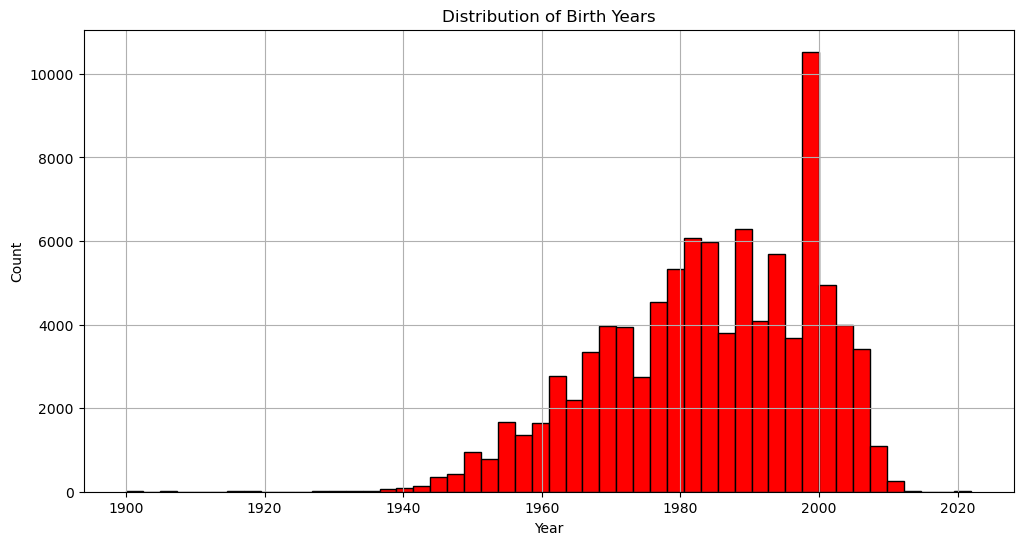

In [396]:
# Plot out the birthdays so I can see outliers
plt.figure(figsize=(12, 6))
plt.hist(users['BIRTH_DATE'].dropna().dt.year, bins=50, color='red', edgecolor='black')
plt.title('Distribution of Birth Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [397]:
# Clean the data in each table: Users
for col in users.select_dtypes(include=['object', 'string']):
    users[col] = users[col].str.strip()

users['GENDER'].unique() # this appears to be form-filleable. There are a number of options here that can be grouped i.e. non_binary and non-binary
users['GENDER'] = users['GENDER'].astype(str)

# merge the non_binary and Non-Binary values
users['GENDER'] = users['GENDER'].str.replace("Non-Binary", "non_binary", case=False)

# merge the: nan, prefer_not_to_say, not_listed, unknown, not_specified, My gender isn't listed, and Prefer not to say
users['GENDER'] = users['GENDER'].str.replace("NaN", "not_specified") # Get rid of NaN values

# I don't want to make too many manipulations to the gender column

#Convert each value to a string so we can sort the NaN values
users['STATE'] = users['STATE'].astype(str)
np.sort(users['STATE'].unique())

unique_states = users['STATE'].nunique() # 53 with DC, PR, and NaN being non-states

# No changes necessary to language as there are only two unique values


In [398]:
users.head()

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54,2000-08-11 00:00:00,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55,2001-09-24 04:00:00,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18,1994-10-28 00:00:00,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22,NaT,NC,en,nan
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50,1972-03-19 00:00:00,PA,en,female


This is the end of the Users data cleaning section

The next section is Products

In [399]:
# Look at the data types of the table
print(products.dtypes)

# Get the number of rows
print(f"Total number of rows: {len(products)}")

CATEGORY_1       object
CATEGORY_2       object
CATEGORY_3       object
CATEGORY_4       object
MANUFACTURER     object
BRAND            object
BARCODE         float64
dtype: object
Total number of rows: 845552


In [400]:
products.head(10)

# Each row is a product
# Categories 1-4 are all descriptive
# Manufacturer has many NaN values
# Brand also has a lot of NaN values
# BARCODE: primary key

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11
5,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,BEAUHAIR,6.626585e+11
6,Health & Wellness,Medicines & Treatments,Vitamins & Herbal Supplements,NaN,HALEON,EMERGEN-C,6.177376e+11
7,Health & Wellness,Deodorant & Antiperspirant,Men's Deodorant & Antiperspirant,NaN,NaN,NaN,7.501839e+12
8,Snacks,Snack Bars,Granola Bars,NaN,HYVEE INC,HY-VEE,7.545013e+10
9,Health & Wellness,NaN,NaN,NaN,CHURCH & DWIGHT,REPHRESH,NaN


In [401]:
# Check for missing data: Products
missing_data = products.isnull().sum()
print(missing_data)

# A ton of missing data
# Missing data from category 1 and 2 is concerning but that probably is data that can be dropped
# Missing data from category 3 and 4 is less concerning because some products may not need that many descriptive categories
# Missing MANUFACTURER is concerning because a product without a manufacturer makes no sense
# There are almost the exact same number of missing values from both BRAND and MANUFACTURER
# Missing BARCODE is the most confusing because it was my impression that this was the primary key of the table

CATEGORY_1         111
CATEGORY_2        1424
CATEGORY_3       60566
CATEGORY_4      778093
MANUFACTURER    226474
BRAND           226472
BARCODE           4025
dtype: int64


In [402]:
# Check for duplicate data: Products
duplicate_mask = products.duplicated()
print(products[duplicate_mask])

# Lots of duplicate rows - 215 rows

products.drop_duplicates(inplace=True)

               CATEGORY_1    CATEGORY_2        CATEGORY_3 CATEGORY_4         MANUFACTURER         BRAND     BARCODE
76394              Snacks         Candy               Gum        NaN  THE HERSHEY COMPANY  ICE BREAKERS   3498507.0
87568              Snacks         Chips            Crisps        NaN         TRADER JOE'S  TRADER JOE'S    952811.0
91710   Health & Wellness     Skin Care               NaN        NaN     BEIERSDORF, INC.    COPPERTONE         NaN
100470             Snacks         Candy  Confection Candy        NaN         LIDL US, LLC          LIDL  20744731.0
109639         Restaurant     Beverages              Soda  Diet Soda              PEPSICO         PEPSI         NaN
...                   ...           ...               ...        ...                  ...           ...         ...
827242             Snacks         Candy   Chocolate Candy        NaN  THE HERSHEY COMPANY     HERSHEY'S   3423905.0
833620             Snacks         Candy   Chocolate Candy        NaN  TH

In [403]:
# Find duplicate barcodes and their counts
duplicate_barcodes = products["BARCODE"][products["BARCODE"].duplicated()].unique()

# Filter products with duplicate barcodes
products_with_duplicates = products[products["BARCODE"].isin(duplicate_barcodes)]

# Count occurrences of each duplicate barcode
duplicate_counts = products["BARCODE"].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]

print("Duplicate Barcodes:")
print(duplicate_barcodes)

print("\nProducts with Duplicate Barcodes:")
print(products_with_duplicates)

print("\nDuplicate Counts:")
print(duplicate_counts)

products = products[~(products["BARCODE"].isin(duplicate_barcodes))]
print(products["BARCODE"].value_counts())

Duplicate Barcodes:
[           nan 7.50530550e+07 4.00320700e+06 2.05224450e+07
 5.04261710e+07 8.71085380e+07 1.70003293e+10 3.43120700e+06
 3.42200700e+06 1.01815800e+06 4.01112160e+07 3.45450300e+06
 8.03101670e+07 7.01983000e+05 4.22084880e+07 9.69307000e+05
 3.60054002e+08 5.23369191e+10 3.48470800e+06 2.07330560e+07
 3.47300900e+06 5.26516900e+06 2.01590780e+07 8.73062860e+07
 2.07332540e+07 2.00310770e+07 8.01991370e+07 4.04310000e+05]

Products with Duplicate Barcodes:
               CATEGORY_1              CATEGORY_2           CATEGORY_3                   CATEGORY_4              MANUFACTURER                  BRAND     BARCODE
9       Health & Wellness                     NaN                  NaN                          NaN           CHURCH & DWIGHT               REPHRESH         NaN
124                Snacks      Jerky & Dried Meat                  NaN                          NaN                   CONAGRA               SLIM JIM         NaN
147                Snacks         

In [404]:
# Summary statistics to find potential outliers
print(products.describe(include='all'))

# There are 86,900 instances of 'PLACEHOLDER MANUFACTURER' in the MANUFACTURER column

               CATEGORY_1 CATEGORY_2        CATEGORY_3 CATEGORY_4              MANUFACTURER      BRAND       BARCODE
count              841204     840654            782603      67230                    615103     615105  8.413150e+05
unique                 27        121               341        126                      4354       8053           NaN
top     Health & Wellness      Candy  Confection Candy  Lip Balms  PLACEHOLDER MANUFACTURER  REM BRAND           NaN
freq               510376     120607             56910       9712                     86892      20813           NaN
mean                  NaN        NaN               NaN        NaN                       NaN        NaN  6.017623e+11
std                   NaN        NaN               NaN        NaN                       NaN        NaN  1.022614e+12
min                   NaN        NaN               NaN        NaN                       NaN        NaN  1.850000e+02
25%                   NaN        NaN               NaN        Na

In [405]:
# Clean the data in each table: products
for col in products.select_dtypes(include=['object', 'string']):
    products[col] = products[col].str.strip()

products[products['BARCODE'].isna()] # 3968 rows
# What do I do with these empty barcodes?


,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE


In [406]:
# Deciding how to handle missing barcodes
print(products['BARCODE'].isna().sum())  # Count of missing barcodes
print(products['BARCODE'].isna().mean() * 100)  # Percentage of missing barcodes

#I don't want to completely get rid of these rows, but since they only make up ~.47% of the rows, I think I can move them to a different dataframe
missing_barcodes = products[products['BARCODE'].isna()] #removed this line so that way it doesn't execute again
products = products[~products['BARCODE'].isna()]

missing_barcodes['BARCODE'] = missing_barcodes['BARCODE'].fillna(
    missing_barcodes.index.to_series().apply(lambda x: f"UNKNOWN_{x}")
)

0
0.0


In [407]:
#missing_barcodes.head()
products.head()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11


In [408]:
# What do I do with 'placeholder manufacturer'?
print((products['MANUFACTURER'] == 'PLACEHOLDER MANUFACTURER').sum())  # Count of missing barcodes: 86,900
print((products['MANUFACTURER'] == 'PLACEHOLDER MANUFACTURER').mean() * 100)  # Percentage of missing barcodes: ~10.3%

#Lets move this to a separate dataframe as well
placeholder_manufacturers = products[products['MANUFACTURER'] == 'PLACEHOLDER MANUFACTURER']
products = products[~(products['MANUFACTURER'] == 'PLACEHOLDER MANUFACTURER')]

86892
10.328117292571747


In [409]:
#placeholder_manufacturers.head()
products.head()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11
6,Health & Wellness,Medicines & Treatments,Vitamins & Herbal Supplements,NaN,HALEON,EMERGEN-C,6.177376e+11


In [410]:
# What to do about the products with NaN manufacturer or brand?
barcodes_for_missing_manufacturer = list(products['BARCODE'][products['MANUFACTURER'].isna()])
barcodes_for_missing_brand = list(products['BARCODE'][products['BRAND'].isna()])

print(f"Total number of missing Manufacturers: {len(barcodes_for_missing_manufacturer)}")
print(f"Total number of missing Brands: {len(barcodes_for_missing_brand)}")

products[products['MANUFACTURER'].isna() | products['BRAND'].isna()] # 226,217 total rows

diff = list(set(barcodes_for_missing_brand).symmetric_difference(set(barcodes_for_missing_manufacturer)))
print(f"Difference is {len(diff)} barcodes: {diff}")

count = 0
for barcode in barcodes_for_missing_manufacturer:
    count += len(transactions[transactions['BARCODE'] == barcode])

print(f"Total number of transactions that involve barcodes from products with either a missing manufacturer or brand is: {count}")


Total number of missing Manufacturers: 226212
Total number of missing Brands: 226210
Difference is 2 barcodes: [12547386653.0, 12547427950.0]
Total number of transactions that involve barcodes from products with either a missing manufacturer or brand is: 738


In [411]:
# Based on my findings from the above cell, I can safely drop the rows with a missing brand or manufacturer
missing_brand_or_manufacturer = products[products['MANUFACTURER'].isna() | products['BRAND'].isna()]
products = products[~(products['MANUFACTURER'].isna() | products['BRAND'].isna())]

In [412]:
#missing_brand_or_manufacturer.head()
products.head()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11
6,Health & Wellness,Medicines & Treatments,Vitamins & Herbal Supplements,NaN,HALEON,EMERGEN-C,6.177376e+11
8,Snacks,Snack Bars,Granola Bars,NaN,HYVEE INC,HY-VEE,7.545013e+10
10,Health & Wellness,Hair Care,Hair Care Accessories,NaN,NONE,SEGO,4.643201e+10


In [413]:
products.head()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11
6,Health & Wellness,Medicines & Treatments,Vitamins & Herbal Supplements,NaN,HALEON,EMERGEN-C,6.177376e+11
8,Snacks,Snack Bars,Granola Bars,NaN,HYVEE INC,HY-VEE,7.545013e+10
10,Health & Wellness,Hair Care,Hair Care Accessories,NaN,NONE,SEGO,4.643201e+10


This is the end of the Products data cleaning section.

The next section is for transactions

In [414]:
print(transactions.dtypes)

# Get the number of rows total
print(f"Total number of rows: {len(transactions)}")

RECEIPT_ID         object
PURCHASE_DATE      object
SCAN_DATE          object
STORE_NAME         object
USER_ID            object
BARCODE           float64
FINAL_QUANTITY     object
FINAL_SALE         object
dtype: object
Total number of rows: 50000


In [415]:
transactions.head(10)

# RECEIPT_ID: primary key
# PURCHASE_DATE: yyyy-mm-dd
# SCAN_DATE: yyyy-mm-dd hh:mm:ss.mssZ
# STORE_NAME: 
# USER_ID: Foreign key
# BARCODE: Foreign key - there are instances of this being NaN?
# FINAL_QUANTITY: final quantity purchased? apparently this can sometimes be 'zero'?
# FINAL_SALE: float value, but sometimes there is nothing?


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,
5,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24 19:44:54.247 Z,WALMART,5dcc6c510040a012b8e76924,6.811314e+11,zero,1.46
6,000550b2-1480-4c07-950f-ff601f242152,2024-07-06,2024-07-06 19:27:48.586 Z,WALMART,5f850bc9cf9431165f3ac175,4.920091e+10,1.00,
7,00096c49-8b04-42f9-88ce-941c5e06c4a7,2024-08-19,2024-08-21 17:35:21.902 Z,TARGET,6144f4f1f3ef696919f54b5c,7.830007e+10,zero,3.59
8,000e1d35-15e5-46c6-b6b3-33653ed3d27e,2024-08-13,2024-08-13 18:21:07.931 Z,WALMART,61a6d926f998e47aad33db66,5.200001e+10,1.00,
9,0010d87d-1ad2-4e5e-9a25-cec736919d15,2024-08-04,2024-08-04 18:01:47.787 Z,ALDI,66686fc2e04f743a096ea808,NaN,zero,2.29


In [416]:
# Check for missing data: Transactions
missing_data = transactions.isnull().sum()
print(missing_data)

# BARCODE is missing ~6000 values, which is concerning because this is the foreign key to products
# Nothing else is missing data, but that doesn't pass the eye test...
# Confusing as to why FINAL_SALE has 0 missing data when looking at transactions.head(10) shows every other value as missing

RECEIPT_ID           0
PURCHASE_DATE        0
SCAN_DATE            0
STORE_NAME           0
USER_ID              0
BARCODE           5762
FINAL_QUANTITY       0
FINAL_SALE           0
dtype: int64


In [417]:
# Check for duplicate data: transactions
duplicate_mask = transactions.duplicated()
print(transactions[duplicate_mask])

# Lots of duplicate rows - 171 rows

# Remove duplicate rows
transactions.drop_duplicates(inplace=True)

                                 RECEIPT_ID PURCHASE_DATE                  SCAN_DATE            STORE_NAME                   USER_ID       BARCODE FINAL_QUANTITY FINAL_SALE
2724   1c12bd8a-c68c-41ee-a26d-294021d3e0b8    2024-09-07  2024-09-07 15:44:35.241 Z                   CVS  65af09757050d0a6206ab136           NaN           1.00           
4192   2acd7e8d-37df-4e51-8ee5-9a9c8c1d9711    2024-09-08  2024-09-08 11:13:01.935 Z               WALMART  663140f9b7b24d45d938f3be  2.400005e+10           1.00           
6572   431fe612-ed55-470e-939c-043ad31f33f3    2024-09-07  2024-09-07 16:39:01.409 Z  DOLLAR GENERAL STORE  5e038cebcb322c11de193bb7  1.200050e+10           1.00           
6623   43955b35-6fbc-4909-a4de-1a0de0dc387f    2024-09-06  2024-09-08 18:32:30.031 Z               WALMART  625364ddda4fb11c8a9fcb85  3.716877e+11           zero      12.97
7675   4ec870d2-c39f-4a40-bf8a-26a079409b20    2024-09-08  2024-09-08 19:39:01.589 Z               WALMART  638e9ae602a4e512e0585b59  7

In [418]:
# Summary statistics to find potential outliers
#print(transactions.describe(include='all'))

# Manipulate the date columns to get better data out of it
transactions['PURCHASE_DATE'] = pd.to_datetime(transactions['PURCHASE_DATE'], errors='coerce')
transactions['SCAN_DATE'] = pd.to_datetime(transactions['SCAN_DATE'], errors='coerce').dt.tz_localize(None)

print(transactions.dtypes)

for col in transactions.select_dtypes(include=['datetime']):
    print(f"Summary for {col}")
    print(f"    Oldest Date: {transactions[col].min()}")
    print(f"    Most Recent Date: {transactions[col].max()}")
    print(f"    Total Days Range: {transactions[col].max() - transactions[col].min()}")
    print()

RECEIPT_ID                object
PURCHASE_DATE     datetime64[ns]
SCAN_DATE         datetime64[ns]
STORE_NAME                object
USER_ID                   object
BARCODE                  float64
FINAL_QUANTITY            object
FINAL_SALE                object
dtype: object
Summary for PURCHASE_DATE
    Oldest Date: 2024-06-12 00:00:00
    Most Recent Date: 2024-09-08 00:00:00
    Total Days Range: 88 days 00:00:00

Summary for SCAN_DATE
    Oldest Date: 2024-06-12 06:36:34.910000
    Most Recent Date: 2024-09-08 23:07:19.836000
    Total Days Range: 88 days 16:30:44.926000



In [419]:
# Clean the data in each table: transactions
for col in transactions.select_dtypes(include=['object', 'string']):
    transactions[col] = transactions[col].str.strip()

transactions.head()

# Now that I have handled empty barcode in Products, I think I can just drop them from the transactions table and set them aside to a new dataframe for potentially more analysis

transactions[transactions['BARCODE'].isna()] # 5735 rows

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
9,0010d87d-1ad2-4e5e-9a25-cec736919d15,2024-08-04,2024-08-04 18:01:47.787,ALDI,66686fc2e04f743a096ea808,NaN,zero,2.29
17,002ee298-d907-40ca-921a-556468571f76,2024-07-15,2024-07-16 16:42:19.211,ALDI,63de64b1dcb50fbd3084f142,NaN,zero,2.49
18,00326689-e763-4b27-9ad5-202fc93609e2,2024-06-19,2024-06-20 08:59:38.397,ALDI,6158642597d737581b5d30ee,NaN,1.00,
60,00a9e033-e49d-45d6-990e-90631f82775e,2024-09-05,2024-09-05 11:10:54.831,ALDI,5d4f08e962fb4a4a58574e7f,NaN,1.00,
...,...,...,...,...,...,...,...,...
49959,45575fc2-6ba3-4913-bdf2-05814e4309e0,2024-06-20,2024-06-20 11:56:29.486,SUPERMERCADOS ECONO,618c25125e388d4f513334b9,NaN,1.00,1.67
49960,7a36db68-c8a7-4b29-b1c2-4cb51ad9f42a,2024-08-29,2024-08-29 14:39:07.868,DOLLAR TREE STORES INC,665e2f887c0469953bfbdb5b,NaN,1.00,1.25
49962,d7cf611f-f07d-4e3d-9a5d-aacc0d56a4a7,2024-07-21,2024-07-21 10:31:52.403,ALDI,61a8f120f6305b3dade12c15,NaN,1.00,1.29
49963,e79c254d-1bf0-4471-8e79-4f52c6b81481,2024-08-24,2024-08-26 15:21:15.492,DOLLAR TREE STORES INC,62f6799b30b23c82198fa01c,NaN,1.00,1.25


In [420]:
# Deciding how to handle missing barcodes
print(transactions['BARCODE'].isna().sum())  # Count of missing barcodes
print(transactions['BARCODE'].isna().mean() * 100)  # Percentage of missing barcodes

#NaN barcode rows makeup ~11.5% of all the transaction
transaction_missing_barcodes = transactions[transactions['BARCODE'].isna()]
transactions = transactions[~transactions['BARCODE'].isna()]

transaction_missing_barcodes['BARCODE'] = transaction_missing_barcodes['BARCODE'].fillna(
    transaction_missing_barcodes.index.to_series().apply(lambda x: f"UNKNOWN_{x}")
)

5735
11.509362018101909


In [421]:
transaction_missing_barcodes.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206,ALDI,62c08877baa38d1a1f6c211a,UNKNOWN_1,zero,1.49
9,0010d87d-1ad2-4e5e-9a25-cec736919d15,2024-08-04,2024-08-04 18:01:47.787,ALDI,66686fc2e04f743a096ea808,UNKNOWN_9,zero,2.29
17,002ee298-d907-40ca-921a-556468571f76,2024-07-15,2024-07-16 16:42:19.211,ALDI,63de64b1dcb50fbd3084f142,UNKNOWN_17,zero,2.49
18,00326689-e763-4b27-9ad5-202fc93609e2,2024-06-19,2024-06-20 08:59:38.397,ALDI,6158642597d737581b5d30ee,UNKNOWN_18,1.00,
60,00a9e033-e49d-45d6-990e-90631f82775e,2024-09-05,2024-09-05 11:10:54.831,ALDI,5d4f08e962fb4a4a58574e7f,UNKNOWN_60,1.00,


In [422]:
transactions.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,
5,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24 19:44:54.247,WALMART,5dcc6c510040a012b8e76924,6.811314e+11,zero,1.46


In [423]:
# It looks like when FINAL_QUANTITY is 1.00, there is no value for FINAL_SALE
# And when there is a value for FINAL_SALE, there is no value for FINAL_QUANTITY

#TODO: make a decision on how to handle the final_sale final_quantity weirdness
print(transactions['FINAL_QUANTITY'].isna().sum()) # this returns 0
print((transactions['FINAL_QUANTITY'] == 'zero').mean() * 100) #~25.09%

# Fix the type error: convert 'zero' to 0.0
transactions['FINAL_QUANTITY'] = transactions['FINAL_QUANTITY'].replace('zero', 0).astype(float)

transactions[transactions['FINAL_QUANTITY'] == 0]

0
25.09865287794258


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,0.0,3.49
5,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24 19:44:54.247,WALMART,5dcc6c510040a012b8e76924,6.811314e+11,0.0,1.46
7,00096c49-8b04-42f9-88ce-941c5e06c4a7,2024-08-19,2024-08-21 17:35:21.902,TARGET,6144f4f1f3ef696919f54b5c,7.830007e+10,0.0,3.59
11,0019ec79-cbb3-41ed-b84c-cd74d04553f8,2024-06-25,2024-06-25 13:15:31.270,COSTCO,5c62145dba25631369c28f32,5.150025e+10,0.0,10.99
13,001f2f3f-1746-4217-a98f-73c63c63bae2,2024-08-20,2024-08-22 12:53:37.811,WALMART,5f57cc80a2b29216020fc68d,4.600029e+10,0.0,0.97
...,...,...,...,...,...,...,...,...
24991,ffebda11-ff18-46e0-8455-cef0679558cc,2024-08-03,2024-08-13 18:36:52.294,DOLLAR GENERAL STORE,65935f6499b40f103b64fc0c,7.940059e+10,0.0,4.25
24993,ffef10cb-52ac-4123-aa87-0d65e85b6ef7,2024-07-21,2024-07-27 19:44:19.898,WALMART,65bfb83d7050d0a6206c7b15,7.940045e+10,0.0,6.97
24995,fff60bb7-bf93-4e6b-8055-4d7688da7ead,2024-08-29,2024-08-29 23:47:50.471,WALMART,5eb887f71699c213b1abe2e1,7.874221e+10,0.0,1.23
24997,fffbb112-3cc5-47c2-b014-08db2f87e0c7,2024-07-30,2024-08-04 11:43:31.474,WALMART,5eb59d6be7012d13941af5e2,8.180000e+11,0.0,4.88


In [424]:
print(transactions['FINAL_SALE'].value_counts()) # 11301 mystery values

mystery_values = transactions[transactions['FINAL_SALE'] == '']
#print(len(mystery_values)) # 11031 total, AKA all of them

# Fix the type error: convert '' to 0.0
transactions['FINAL_SALE'] = transactions['FINAL_SALE'].replace('', 0).astype(float)

print((transactions['FINAL_SALE'] == 0).mean() * 100) # ~25.43%

transactions.head()


FINAL_SALE
         11031
1.25      1106
1.00       675
2.00       510
2.99       500
         ...  
8.64         1
7.45         1
10.79        1
13.14        1
7.83         1
Name: count, Length: 1301, dtype: int64
25.4048169819023


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.0,0.00
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.0,0.00
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,0.0,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.0,0.00
5,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24 19:44:54.247,WALMART,5dcc6c510040a012b8e76924,6.811314e+11,0.0,1.46


In [425]:
# All the transactions where both final quantity and sale as 0
transactions[(transactions['FINAL_QUANTITY'] == 0) & (transactions['FINAL_SALE'] == 0)]
transactions = transactions[~((transactions['FINAL_QUANTITY'] == 0) & (transactions['FINAL_SALE'] == 0))] # remove them

transactions = transactions.sort_values(by='RECEIPT_ID')
transactions

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.0,0.00
41567,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.0,1.54
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.0,0.00
25928,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.0,2.54
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,0.0,3.49
...,...,...,...,...,...,...,...,...
28152,fffbb112-3cc5-47c2-b014-08db2f87e0c7,2024-07-30,2024-08-04 11:43:31.474,WALMART,5eb59d6be7012d13941af5e2,8.180000e+11,1.0,4.88
31602,fffbfb2a-7c1f-41c9-a5da-628fa7fcc746,2024-07-28,2024-07-28 11:47:34.180,WALMART,62a0c8f7d966665570351bb8,1.300001e+10,1.0,3.48
24998,fffbfb2a-7c1f-41c9-a5da-628fa7fcc746,2024-07-28,2024-07-28 11:47:34.180,WALMART,62a0c8f7d966665570351bb8,1.300001e+10,1.0,0.00
24999,fffe8012-7dcf-4d84-b6c6-feaacab5074a,2024-09-07,2024-09-08 08:21:25.648,WALGREENS,5f53c62bd683c715b9991b20,7.432310e+10,0.0,2.98


In [426]:
print(transactions['FINAL_QUANTITY'].value_counts()) # 11010 0.0 values
print(transactions['FINAL_SALE'].value_counts()) # 11145 0.0 values

FINAL_QUANTITY
1.00    31440
0.00    11010
2.00     1162
3.00      157
4.00      121
        ...  
2.57        1
1.37        1
0.99        1
2.04        1
0.87        1
Name: count, Length: 67, dtype: int64
FINAL_SALE
0.00     11145
1.25      1106
1.00       675
2.00       510
2.99       500
         ...  
7.35         1
18.12        1
0.12         1
19.44        1
34.99        1
Name: count, Length: 1300, dtype: int64


This is the end of the data cleaning section

In [427]:
# Export the cleaned dfs to new csv files to be used in SQL querying
file_path = os.path.join("cleaned", "users.csv")
print(file_path)

# The important cleaned dataframes
users.to_csv("cleaned/users.csv")
products.to_csv("cleaned/products.csv")
transactions.to_csv("cleaned/transactions.csv")

# Save these for later analysis
missing_barcodes.to_csv("cleaned/missing_barcodes.csv")
placeholder_manufacturers.to_csv("cleaned/placeholder_manufacturers.csv")
missing_brand_or_manufacturer.to_csv("cleaned/missing_brand_or_manufacturer.csv")
transaction_missing_barcodes.to_csv("cleaned/transaction_missing_barcodes.csv")

cleaned/users.csv
